AI BASED RESEARCH AND REASONING MULTI AGENT SYSTEM

In [1]:
# --- 1. Imports and Setup ---
import os
from typing import TypedDict, List
from dotenv import load_dotenv

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

print("✅ Libraries imported successfully.")

✅ Libraries imported successfully.


In [2]:
# --- 2. Load Environment Variables ---
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

if not OPENAI_API_KEY or not TAVILY_API_KEY:
    raise ValueError("❌ Missing API keys. Please set OPENAI_API_KEY and TAVILY_API_KEY in your .env file.")

print("🔑 Environment variables loaded successfully.")


🔑 Environment variables loaded successfully.


In [3]:
# --- 3. Define State Structure ---
class AgentState(TypedDict):
    messages: List[BaseMessage]
    topic: str
    report: str

print("📘 AgentState schema defined.")


📘 AgentState schema defined.


In [4]:
# --- 4. Initialize Tools and Models ---
print("⚙️ Initializing tools and models...")

tavily_tool = TavilySearchResults(max_results=4, description="A search engine tool")
tools = [tavily_tool]
tool_node = ToolNode(tools=tools)

model = ChatOpenAI(model="gpt-4o", temperature=0, api_key=OPENAI_API_KEY)

try:
    research_model = model.bind_tools(tools)
    print("✅ Model bound with tools.")
except Exception:
    research_model = model
    print("⚠️ bind_tools() not available; using model without binding.")

print("✅ Tools and models initialized.")


⚙️ Initializing tools and models...
✅ Model bound with tools.
✅ Tools and models initialized.


In [5]:
# --- 5. Define Node Functions (inline in notebook) ---

def researcher_node(state: AgentState):
    topic = state.get("topic", "")
    print(f"🔍 Researching topic: {topic}")
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a world-class researcher. Use the search tool to find the most relevant and up-to-date information on the given topic."),
        ("human", "Please research the topic: {topic}")
    ])
    runnable = prompt | research_model
    response = runnable.invoke({"topic": topic})
    return {"messages": [response]}

def analyst_node(state: AgentState):
    print("📊 Running Analyst Node...")
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a senior research analyst. Summarize key insights from the search results."),
        ("user", "Here are the search results: {search_results}")
    ])
    runnable = prompt | model
    last_msg = state["messages"][-1]
    search_content = getattr(last_msg, "content", str(last_msg))
    response = runnable.invoke({"search_results": search_content})
    return {"messages": [response]}

def writer_node(state: AgentState):
    print("✍️ Writing final report...")
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a professional report writer. Create a structured report with title, executive summary, and insights."),
        ("user", "Here are the insights: {insights}")
    ])
    runnable = prompt | model
    last_msg = state["messages"][-1]
    insights = getattr(last_msg, "content", str(last_msg))
    response = runnable.invoke({"insights": insights})
    return {"messages": [response], "report": getattr(response, "content", str(response))}
print("✅ Node functions defined.")

✅ Node functions defined.


In [6]:
# --- 6. Build the Graph ---
print("🧩 Building the LangGraph workflow...")

workflow = StateGraph(AgentState)
workflow.add_node("researcher", researcher_node)
workflow.add_node("tool_node", tool_node)
workflow.add_node("analyst", analyst_node)
workflow.add_node("writer", writer_node)

workflow.set_entry_point("researcher")
workflow.add_edge("researcher", "tool_node")
workflow.add_edge("tool_node", "analyst")
workflow.add_edge("analyst", "writer")
workflow.add_edge("writer", END)

app = workflow.compile()

print("✅ Graph compiled successfully.")


🧩 Building the LangGraph workflow...
✅ Graph compiled successfully.


🧱 ASCII Representation of the Graph:
+-----------+  
| __start__ |  
+-----------+  
       *       
       *       
       *       
+------------+ 
| researcher | 
+------------+ 
       *       
       *       
       *       
+-----------+  
| tool_node |  
+-----------+  
       *       
       *       
       *       
  +---------+  
  | analyst |  
  +---------+  
       *       
       *       
       *       
  +--------+   
  | writer |   
  +--------+   
       *       
       *       
       *       
  +---------+  
  | __end__ |  
  +---------+  
None


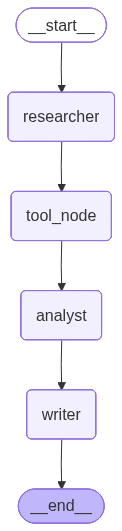

✅ Displayed workflow graph as image.


In [8]:
# --- 7. Visualize the Graph (Updated for new LangGraph) ---

print("🧱 ASCII Representation of the Graph:")

try:
    # In latest versions, visualization is available from the compiled app
    print(app.get_graph().print_ascii())
except AttributeError:
    try:
        # Fallback: some builds use .print_ascii() directly
        print(workflow.print_ascii())
    except AttributeError:
        print("⚠️ This version of LangGraph does not support .print_ascii(). Try upgrading to latest version.")

# Optional: Mermaid or PNG visualization
try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
    print("✅ Displayed workflow graph as image.")
except Exception as e:
    print("⚠️ Could not render image graph (try installing graphviz):", e)


In [9]:
# --- 8. Run the Graph ---
topic = "Latest advancements in AI-powered drug discovery"

inputs = {
    "topic": topic,
    "messages": [HumanMessage(content=f"Research the topic: {topic}")],
    "report": ""
}

print(f"🚀 Running the graph for topic: {topic}")
final_state = app.invoke(inputs)

final_report = final_state.get("report", "")
print("✅ Run complete.")

from IPython.display import Markdown, display
if final_report:
    display(Markdown(final_report))
else:
    print("❌ No report generated.")


🚀 Running the graph for topic: Latest advancements in AI-powered drug discovery
🔍 Researching topic: Latest advancements in AI-powered drug discovery
📊 Running Analyst Node...
✍️ Writing final report...
✅ Run complete.


# Report: The Transformative Impact of Artificial Intelligence on Drug Discovery and Development

## Executive Summary

The integration of artificial intelligence (AI) into drug discovery and development is revolutionizing the pharmaceutical industry. This report explores the key insights into how AI is reshaping the drug development landscape, addressing traditional challenges, and creating new economic opportunities. AI's ability to enhance target identification, improve economic and time efficiency, and attract significant investment underscores its transformative potential. As AI continues to evolve, it is expected to significantly increase the success rate of developing new therapies, offering a promising future for the industry.

## Insights

### 1. AI Integration in Drug Development

AI is being seamlessly integrated across the entire drug development workflow, from disease target identification to drug discovery. This integration is crucial in addressing the inherent challenges of traditional drug development methods, which are often characterized by high costs, lengthy timelines, and high failure rates. By leveraging AI, pharmaceutical companies can streamline processes, enhance precision, and improve outcomes.

### 2. Advancements in Target Identification

AI is playing a pivotal role in enhancing the process of therapeutic target exploration. It enables the analysis of large datasets and complex biological networks, making target identification more efficient. This advancement not only increases the success rate of drug development but also accelerates the validation of AI-identified targets. Notably, some AI-derived drugs are already entering clinical trials, marking a significant milestone in the industry.

### 3. Economic and Time Efficiency

The traditional drug discovery process is both expensive and time-consuming, with pre-clinical stages alone taking three to six years and costing hundreds of millions to billions of dollars. AI tools are revolutionizing this process by potentially reducing both the time and cost involved. This shift is reshaping the economics of the industry, making drug development more accessible and sustainable.

### 4. Investment and Market Potential

The potential of AI in drug discovery has captured the attention of investors, leading to increased third-party investment in AI-enabled drug discovery. According to Morgan Stanley, even modest improvements in early-stage drug development success rates through AI could lead to the creation of 50 novel therapies over a decade. This represents a market opportunity exceeding $50 billion, highlighting the significant economic potential of AI in this field.

## Conclusion

AI is poised to revolutionize drug discovery by improving efficiency, reducing costs, and increasing the success rate of developing new therapies. As the pharmaceutical industry continues to embrace AI, it is expected to unlock unprecedented opportunities for innovation and growth. The transformative impact of AI on drug discovery and development is not only reshaping the industry but also paving the way for a new era of medical advancements.

In [ ]:
# # --- 9. Display Final Report ---
# from IPython.display import Markdown, display

# if final_report:
#     print("📄 Final Report Generated:")
#     display(Markdown(final_report))
# else:
#     print("❌ No report generated.")

# # Save to file
# with open("report.md", "w", encoding="utf-8") as f:
#     f.write(final_report)

# print("💾 Report saved as report.md")


📄 Final Report Generated:


# Report on the Application of Artificial Intelligence in Drug Discovery

## Executive Summary

The integration of artificial intelligence (AI) into drug discovery is revolutionizing the pharmaceutical industry. This report outlines the transformative role AI plays in enhancing the efficiency, speed, and success rates of drug development. AI's application spans from target identification to clinical trials, offering significant economic opportunities and attracting substantial investment. Despite the promising advancements, challenges remain that need to be addressed to fully harness AI's potential in this field.

## Key Insights

1. **AI's Transformative Role**: 
   - AI is significantly altering the traditional drug discovery process, which is known for being time-consuming and costly.
   - AI tools are now integrated into nearly every stage of drug discovery, from target identification to clinical trials, with the potential to accelerate timelines and reduce costs.

2. **Economic Impact**:
   - The integration of AI in drug discovery represents not only a scientific advancement but also a substantial economic opportunity.
   - According to Morgan Stanley, even modest improvements in early-stage drug development success rates through AI could lead to the creation of 50 novel therapies over a decade, representing a potential $50 billion market opportunity.

3. **Investment Trends**:
   - There is a growing interest from investors in AI-enabled drug discovery, evidenced by increasing third-party investments in the sector.
   - This interest is driven by AI's potential to improve success rates and efficiency in drug development.

4. **Technological Advancements**:
   - AI technologies, including deep learning and multiomics, are advancing the field of drug discovery.
   - These technologies are particularly impactful in disease modeling and target identification, which are crucial initial steps in the drug development process.

5. **AI-Driven Target Discovery**:
   - AI is playing a growing role in modern drug target identification, traditionally a lengthy process.
   - AI's ability to analyze large datasets and complex biological networks is enhancing the efficiency and success rates of target discovery.

6. **Clinical Trials and Validation**:
   - An increasing number of AI-identified drug targets are being validated through experiments.
   - Several AI-derived drugs are entering clinical trials, marking a significant step forward in the practical application of AI in pharmaceuticals.

7. **Challenges and Future Directions**:
   - Despite the benefits, there are current limitations and challenges that need to be addressed.
   - These include balancing novelty and confidence in target selection and overcoming technical and regulatory hurdles to fully realize AI's potential in drug discovery.

In conclusion, AI is poised to revolutionize the pharmaceutical industry by enhancing the speed, efficiency, and success rates of drug discovery and development. However, addressing the existing challenges will be crucial to fully leverage AI's capabilities in this transformative journey.

💾 Report saved as report.md
